In [2]:
# ==== One-shot Kaggle + Drive setup (Colab) ====
MODE = "dataset"  # "dataset" or "competition"
KAGGLE_REF = "jonathanoheix/face-expression-recognition-dataset"
DRIVE_DATA_DIR = "/content/drive/MyDrive/kaggle_data/face-expression-recognition-dataset"
MAKE_WORKING_COPY = True
FORCE_DOWNLOAD = False  # set True to refresh even if cached

# --------------------------------------------------------------------------
import os, sys, zipfile, shutil, textwrap, json, subprocess
from pathlib import Path

def pip_install(pkg):
    try:
        __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

pip_install("kaggle")

from google.colab import drive
try:
    drive.mount("/content/drive")
except Exception:
    # If you see "already mounted", that's fine. Force remount if you want.
    drive.mount("/content/drive", force_remount=True)


# --- Prepare target dirs ---
DRIVE_DATA_DIR = Path(DRIVE_DATA_DIR)
DRIVE_DATA_DIR.mkdir(parents=True, exist_ok=True)

WORK_DIR = Path("/content/kaggle_work")

print("\nPaths:")
print("  Persistent (Drive):", DRIVE_DATA_DIR)
print("  Working (Runtime) :", WORK_DIR if MAKE_WORKING_COPY else "(disabled)")

Mounted at /content/drive

Paths:
  Persistent (Drive): /content/drive/MyDrive/kaggle_data/face-expression-recognition-dataset
  Working (Runtime) : /content/kaggle_work


In [3]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install torch
! pip install torchvision
! pip install torchmetrics
! pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
batch_size = 100

data_dir = DRIVE_DATA_DIR / 'images'

# Định nghĩa cho tập TRAIN (Có Augmentation)
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),

    # Agument data
    transforms.RandomHorizontalFlip(p=0.5), # 50% cơ hội lật ảnh
    transforms.RandomRotation(15),           # Xoay tối đa 15 độ
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Dịch chuyển ảnh nhẹ

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Định nghĩa cho tập TEST (Khong co Augmentation)
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform_train)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/validation", transform=transform_test)

train_loader = DataLoader(batch_size=batch_size, dataset=train_dataset, shuffle=True)
test_loader = DataLoader(batch_size=batch_size, dataset=test_dataset, shuffle=True)

In [7]:
all_labels = train_dataset.targets
unique_labels, counts = np.unique(all_labels, return_counts=True)

total_samples = len(train_dataset)
num_classes = len(unique_labels)

weights = [total_samples / (num_classes * c) for c in counts]
class_weights = torch.FloatTensor(weights).to(device)

print(f"Số lượng mẫu đếm được: {counts}")
print(f"Trọng số tương ứng: {weights}")

Số lượng mẫu đếm được: [3993  436 4103 7164 4982 4939 3205]
Trọng số tương ứng: [np.float64(1.031161675789775), np.float64(9.443643512450851), np.float64(1.003516590647958), np.float64(0.5747387732312356), np.float64(0.8264609737913632), np.float64(0.8336563214068782), np.float64(1.2846891018497884)]


In [8]:
x, y = train_dataset[0]
print(x.shape)

torch.Size([1, 48, 48])


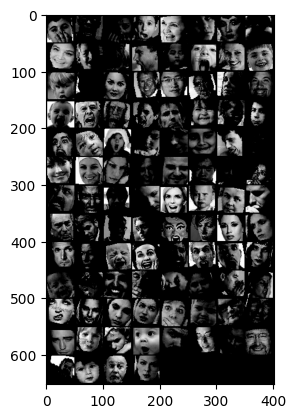

In [ ]:
def img_show(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# get some random image
data_iter = iter(train_loader)
images, labels = next(data_iter)

labels

img_show(torchvision.utils.make_grid(images))

In [9]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        """
        Building blocks of convolutional neural network.
        Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 7 (i.e 7 emotions).
        """
        super(CNN, self).__init__()

        # Các lớp trích xuất đặc trưng (Feature Extraction)
        """
        Conv2d: Nhìn và tìm đặc trưng.

        BatchNorm2d: Chuẩn hóa dữ liệu cho lớp sau dễ học.

        ReLU: Loại bỏ các giá trị âm (không quan trọng).

        MaxPool2d: Tóm tắt lại những gì vừa nhìn thấy.

        Dropout: Ép mô hình học kĩ, không học vẹt.
        """

        self.features = nn.Sequential(
            # Block 1: 48x48 -> 24x24
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2nd convolution layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3nd convolution layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 4nd convolution layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((1,1)) # Gom về 256 con số
        )

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: Input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = self.features(x) # Output: (Batch, 16, 1, 1)
        x = torch.flatten(x, 1) # Biến thành vector: (Batch, 16)
        x = self.fc(x) # Dự đoán: (Batch, 10)

        return x

In [10]:
model = CNN(in_channels=1, num_classes=7).to(device)

model_path = f"{DRIVE_DATA_DIR}/emotion_model.pth"

In [11]:
# define loss function
loss = nn.CrossEntropyLoss(weight=class_weights)

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Nếu Val Accuracy không tăng sau 5 epoch, giảm LR đi một nửa
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=5)

In [ ]:
num_epochs = 50
best_accuracy = 0.0

for epoch in range(num_epochs):
    print(f"{epoch+1}/{num_epochs}")

    model.train() # enable Dropout BatchNorm
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0

    loop = tqdm(train_loader, leave=True)

    for data, targets in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        loss_value = loss(scores, targets)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        # Tính toán số liệu ngay trong lúc train
        running_loss += loss_value.item()
        _, predictions = scores.max(1)
        correct_train += (predictions == targets).sum().item()
        total_train += targets.size(0)

        # Cập nhật thanh tiến trình
        loop.set_description(f"Loss: {loss_value.item():.4f}")

    train_acc = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)

    # --- GIAI ĐOẠN EVALUATION (Kiểm tra sau mỗi Epoch) ---
    model.eval() # Tắt Dropout, dùng BatchNorm ở chế độ dự đoán

    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad(): # Không tính đạo hàm để tiết kiệm RAM/GPU
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            v_loss = loss(scores, targets)
            val_loss += v_loss.item()

            _, predictions = scores.max(1)
            correct_val += (predictions == targets).sum().item()
            total_val += targets.size(0)

    val_acc = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(test_loader)


    # Trong vòng lặp train, sau khi eval xong:
    scheduler.step(avg_val_loss)

    # In kết quả tổng kết sau 1 Epoch
    print(f"Result -> Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"          Val Loss: {avg_val_loss:.4f}   | Val Acc: {val_acc:.2f}%")

    # Lưu lại model tốt nhất (Best Model)
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"==> Đã lưu mô hình tốt nhất với độ chính xác: {val_acc:.2f}%")

1/50


Loss: 1.8712:   9%|▉         | 26/289 [09:29<1:19:39, 18.17s/it]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model = CNN(in_channels=1, num_classes=7).to(device)

model.load_state_dict(torch.load(model_path))

model.eval()
all_preds = []
all_labels = []

categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs, 1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("--- EVALUATION REPORT ---")
print(classification_report(all_labels, all_preds, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
print(df_cm)


--- EVALUATION REPORT ---
              precision    recall  f1-score   support

       angry       0.50      0.60      0.54       960
     disgust       0.51      0.71      0.59       111
        fear       0.51      0.39      0.44      1018
       happy       0.87      0.82      0.84      1825
     neutral       0.65      0.56      0.60      1216
         sad       0.48      0.56      0.52      1139
    surprise       0.71      0.78      0.75       797

    accuracy                           0.64      7066
   macro avg       0.60      0.63      0.61      7066
weighted avg       0.64      0.64      0.64      7066

          angry  disgust  fear  happy  neutral  sad  surprise
angry       574       26    72     36       77  151        24
disgust      18       79     3      1        2    5         3
fear        176       17   398     40       70  202       115
happy        67        3    37   1494       75   90        59
neutral     128        6    57     86      684  226        29
sad  